In [140]:
import os
print(os.getcwd())

C:\Users\Zi Ye\Documents\intern\ml-latest-small


### This project was to perform unsupervised learning for movie recommendations. The object of this study was to:
1. Data wrangling
2. Data visualization using PCA and t-SNE to identify potential number of clusters (of users)
3. Distance analysis / clustering analysis such as k -means cluster to identify interest groups
4. Movie recommendation for each user based on ratings of unwatched movies in the interest groups

In [4]:
import numpy as np
import pandas as pd
import matplotlib as mlp

In [85]:
Rating_df=pd.read_csv('ratings.csv')
print(Rating_df.head())
Rating_df.describe()

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [86]:
#check if the every user watched the same set of movies
dfC=Rating_df.groupby('userId').movieId.count()


In [87]:
#total number of movies
Movies=Rating_df.movieId.unique()
Movies
Users=Rating_df.userId.unique()

# 1.1 Data wrangling: Build a matrix composed of ratings, movie ID, and user ID

In [274]:
MovieDF=pd.DataFrame(index=Movies)
for i in Users:
    tempMovie=Rating_df[Rating_df.userId==i]['rating']
    tempMovie.index=Rating_df[Rating_df.userId==i]['movieId']
    MovieDF=Rating_df.concat([MovieDF, tempMovie], axis=1)

In [277]:
MovieDF.columns=Users
MovieDF.index=Movies
MovieDF.head()

,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
3,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
6,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
47,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [278]:
MovieDF.to_csv('movie.csv')

# 1.2 Data wrangling: Collapsing movies by genre  

In [89]:
genreDF = pd.read_csv('movies.csv')
genreDF.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


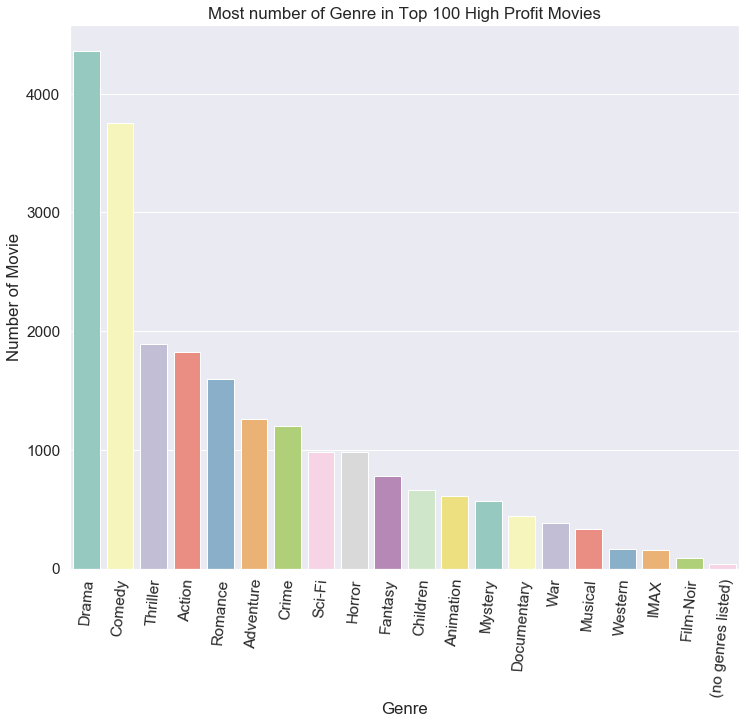

In [90]:
#get the total number of genres
import operator

genre_dict = {}
genre_list = set()

genres = genreDF["genres"]
genres = genres.str.split("|")
genres = np.array(genres)
for m in genres:
    #check if there is a problematic list which is just a float
    for g in m:
        g = g.lstrip() #trim the whitespaces
        if g not in genre_dict:
            genre_dict[g] = 1
            genre_list.add(g)
        else:
            genre_dict[g] += 1
                
sorted_genre_dict = sorted(genre_dict.items(), key = operator.itemgetter(1), reverse = True)

x_axis = list()
y_axis = list()

for item in sorted_genre_dict[0:20]:
    x_axis.append(item[0])
    y_axis.append(item[1])


sns.set(rc={'figure.figsize':(12,10)}, font_scale=1.4)
ax = sns.barplot(x_axis, y_axis, palette="Set3")


#rotate x-axis' text
for item in ax.get_xticklabels():
    item.set_rotation(85)
    

ax.set(xlabel='Genre', ylabel='Number of Movie', title = 'Most number of Genre in Top 100 High Profit Movies')
plt.show()



In [93]:
print(genre_list)
genre_list=list(genre_list)
genre_list_rating = [sub + "_Ave_Rating" for sub in genre_list] 
print(genre_list_rating)

{'(no genres listed)', 'Crime', 'Western', 'Documentary', 'Fantasy', 'Action', 'Animation', 'Comedy', 'Adventure', 'Romance', 'War', 'IMAX', 'Children', 'Musical', 'Horror', 'Drama', 'Thriller', 'Sci-Fi', 'Film-Noir', 'Mystery'}
['(no genres listed)_Ave_Rating', 'Crime_Ave_Rating', 'Western_Ave_Rating', 'Documentary_Ave_Rating', 'Fantasy_Ave_Rating', 'Action_Ave_Rating', 'Animation_Ave_Rating', 'Comedy_Ave_Rating', 'Adventure_Ave_Rating', 'Romance_Ave_Rating', 'War_Ave_Rating', 'IMAX_Ave_Rating', 'Children_Ave_Rating', 'Musical_Ave_Rating', 'Horror_Ave_Rating', 'Drama_Ave_Rating', 'Thriller_Ave_Rating', 'Sci-Fi_Ave_Rating', 'Film-Noir_Ave_Rating', 'Mystery_Ave_Rating']


In [94]:
#Get the ave ratings for each genre per user 
def Get_Genre_Ratings(Rating_df, genreDF, genres, column_names):
    Genre_ratingsDF = pd.DataFrame()
    for genre in genres:        
        Genre_Movies = genreDF[genreDF['genres'].str.contains(genre)]
        Avg_Genre_Score_Per_User = Rating_df[Rating_df['movieId'].isin(Genre_Movies['movieId'])].loc[:,['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        Genre_ratingsDF = pd.concat([Genre_ratingsDF, Avg_Genre_Score_Per_User], axis=1)        
    Genre_ratingsDF.columns = column_names
    return Genre_ratingsDF

# Calculate the average rating of romance and scifi movies
Genre_ratingsDF = Get_Genre_Ratings(Rating_df, genreDF,genre_list, genre_list_rating)
Genre_ratingsDF.head()

C:\Users\Zi Ye\anaconda3\lib\site-packages\pandas\core\strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,(no genres listed)_Ave_Rating,Crime_Ave_Rating,Western_Ave_Rating,Documentary_Ave_Rating,Fantasy_Ave_Rating,Action_Ave_Rating,Animation_Ave_Rating,Comedy_Ave_Rating,Adventure_Ave_Rating,Romance_Ave_Rating,War_Ave_Rating,IMAX_Ave_Rating,Children_Ave_Rating,Musical_Ave_Rating,Horror_Ave_Rating,Drama_Ave_Rating,Thriller_Ave_Rating,Sci-Fi_Ave_Rating,Film-Noir_Ave_Rating,Mystery_Ave_Rating
1,NaN,4.36,4.29,NaN,4.30,4.32,4.69,4.28,4.39,4.31,4.50,NaN,4.55,4.68,3.47,4.53,4.15,4.22,5.0,4.17
2,NaN,3.80,3.50,4.33,NaN,3.95,NaN,4.00,4.17,4.50,4.50,3.75,NaN,NaN,3.00,3.88,3.70,3.88,NaN,4.00
3,NaN,0.50,NaN,NaN,3.38,3.57,0.50,1.00,2.73,0.50,0.50,NaN,0.50,0.50,4.69,0.75,4.14,4.20,NaN,5.00
4,NaN,3.81,3.80,4.00,3.68,3.32,4.00,3.51,3.66,3.38,3.57,3.00,3.80,4.00,4.25,3.48,3.55,2.83,4.0,3.48
5,NaN,3.83,3.00,NaN,4.14,3.11,4.33,3.47,3.25,3.09,3.33,3.67,4.11,4.40,3.00,3.80,3.56,2.50,NaN,4.00


# 2. Data visualization using PCA and t-SNE to identify potential number of clusters (of users interest groups) and visualize data structure


In [2]:
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score

%matplotlib inline

# 2.1 Visualisation: Plot PCA and t-SNE for all movies

In [106]:
movie_df=pd.read_csv('movie.csv')
movie_df.head()

,Unnamed: 0,1,2,3,4,5,6,7,8,9,...,601,602,603,604,605,606,607,608,609,610
0,1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
1,3,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
2,6,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
3,47,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,50,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


#### PCA

In [19]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA
#from sklearn.preprocessing import StandardScaler
#%matplotlib inlinefrom sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# Standardizing the features
#x = StandardScaler().fit_transform(x)

In [107]:
#pca
movie_df2=movie_df.copy()
movie_df2=movie_df2.fillna(0)
x = movie_df2.values
#principalComponents = pca.fit_transform(x)
features = movie_df2.columns
#pca = PCA(n_components=2)
pca.fit(x)
pca = PCA(n_components=3)
pca_result = pca.fit_transform(movie_df2.values)
movie_df2['pca-one'] = pca_result[:,0]
movie_df2['pca-two'] = pca_result[:,1] 
movie_df2['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

#t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(x)
movie_df2['tsne-2d-one'] = tsne_results[:,0]
movie_df2['tsne-2d-two'] = tsne_results[:,1]
print('t-SNE is done!')

Explained variation per principal component: [9.99999952e-01 8.45423565e-09 2.00090390e-09]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9724 samples in 1.401s...
[t-SNE] Computed neighbors for 9724 samples in 2.334s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9724
[t-SNE] Computed conditional probabilities for sample 2000 / 9724
[t-SNE] Computed conditional probabilities for sample 3000 / 9724
[t-SNE] Computed conditional probabilities for sample 4000 / 9724
[t-SNE] Computed conditional probabilities for sample 5000 / 9724
[t-SNE] Computed conditional probabilities for sample 6000 / 9724
[t-SNE] Computed conditional probabilities for sample 7000 / 9724
[t-SNE] Computed conditional probabilities for sample 8000 / 9724
[t-SNE] Computed conditional probabilities for sample 9000 / 9724
[t-SNE] Computed conditional probabilities for sample 9724 / 9724
[t-SNE] Mean sigma: 15.638764
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.17265

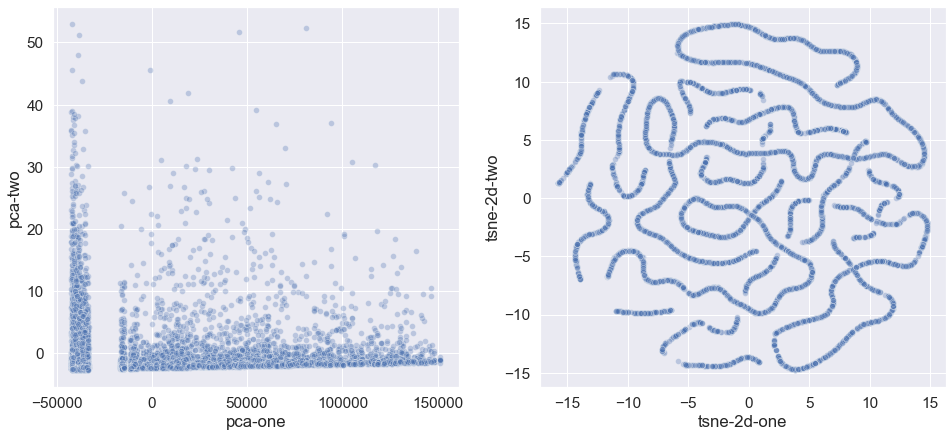

In [108]:
#plot

plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    palette=sns.color_palette("hls", 10),
    data=movie_df2,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x=movie_df2['tsne-2d-one'], y=movie_df2['tsne-2d-two'],
    
    palette=sns.color_palette("hls", 10),
    data=movie_df2,
    legend="full",
    alpha=0.3,
    ax=ax2
)

In [25]:
print(pca.components_)

[[ 1.00000000e+00 -7.01647113e-07 -6.71101962e-08 ... -8.23538059e-07
  -1.36722538e-07 -1.25751481e-07]
 [ 6.02046029e-06  5.93380669e-02  6.25910467e-03 ...  1.18457242e-01
   8.48951881e-03  1.22056298e-01]]


# 2.2 Visualisation: Plot PCA and t-SNE for all genres


In [100]:
#pca
Genre_ratingsDF2=Genre_ratingsDF.copy()
Genre_ratingsDF2=Genre_ratingsDF2.fillna(0)
x = Genre_ratingsDF2.values
principalComponents = pca.fit_transform(x)
features = Genre_ratingsDF2.columns
#pca = PCA(n_components=2)
pca.fit(x)
pca = PCA(n_components=3)
pca_result = pca.fit_transform(Genre_ratingsDF2.values)
Genre_ratingsDF2['pca-one'] = pca_result[:,0]
Genre_ratingsDF2['pca-two'] = pca_result[:,1] 
Genre_ratingsDF2['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))



Explained variation per principal component: [0.23535737 0.16280069 0.10512037]


In [104]:

#t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(x)
Genre_ratingsDF2['tsne-2d-one'] = tsne_results[:,0]
Genre_ratingsDF2['tsne-2d-two'] = tsne_results[:,1]
print('t-SNE is done!')

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 610 samples in 0.002s...
[t-SNE] Computed neighbors for 610 samples in 0.025s...
[t-SNE] Computed conditional probabilities for sample 610 / 610
[t-SNE] Mean sigma: 1.921632
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.488670
[t-SNE] KL divergence after 300 iterations: 0.733472
t-SNE is done!


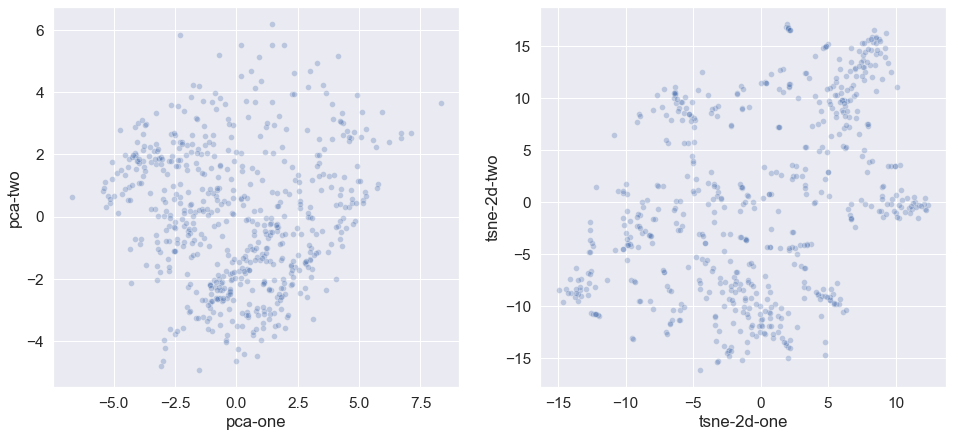

In [105]:
#plot

plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    palette=sns.color_palette("hls", 10),
    data=Genre_ratingsDF2,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x=Genre_ratingsDF2['tsne-2d-one'], y=Genre_ratingsDF2['tsne-2d-two'],
    
    palette=sns.color_palette("hls", 10),
    data=Genre_ratingsDF2,
    legend="full",
    alpha=0.3,
    ax=ax2
)


# 3.0 Identify similar person by cosine similarity

In [212]:
from sklearn.preprocessing import normalize
#for all movies
movie_df2=movie_df.copy()
movie_df2=movie_df2.fillna(0)
#movie_df2[movie_df2<0]=0.01
norm_features = normalize(movie_df2)
df = pd.DataFrame(norm_features, index=movie_df2.index)
Person = df.loc[1]
similarities = df.dot(Person)
print('Based on all movies, the most similar person is \n {} .'.format(str(similarities.nlargest())))

#for all genre
Genre_ratingsDF2=Genre_ratingsDF.fillna(0)
Genre_ratingsDF2[Genre_ratingsDF2<0]=0.01
norm_features = normalize(Genre_ratingsDF2)
df = pd.DataFrame(norm_features, index=Genre_ratingsDF2.index)
Person = df.loc[1]
similarities = df.dot(Person)
print('Based on all genre, the most similar person is \n {} .'.format(str(similarities.nlargest())))

Based on all movies, the most similar person is 
 1      1.000000
483    0.522656
0      0.410540
506    0.383454
484    0.356174
dtype: float64 .
Based on all genre, the most similar person is 
 1      1.000000
452    0.997637
217    0.996620
422    0.995717
465    0.995356
dtype: float64 .


# 3.1 k-means clustering and results

### for all movie dataset

In [213]:
# Importing Modules
from sklearn import datasets
from sklearn.cluster import KMeans

# Declaring Model
model = KMeans(n_clusters=8)

# Fitting Model
model.fit(movie_df2.values)

# Predicitng a single input
#predicted_label = model.predict([[7.2, 3.5, 0.8, 1.6]])

# Prediction on the entire data
all_predictions = model.predict(movie_df2.values)

# Printing Predictions
#print(predicted_label)
print(all_predictions)

[1 1 1 ... 6 6 6]


In [214]:
# Result visualisation for all movies dataset
#pca
movie_df2=movie_df.copy()
movie_df2=movie_df2.fillna(0)
x = movie_df2.values
y=all_predictions
#principalComponents = pca.fit_transform(x)
features = movie_df2.columns
#pca = PCA(n_components=2)
pca.fit(x)
pca = PCA(n_components=3)
pca_result = pca.fit_transform(movie_df2.values)
movie_df2['pca-one'] = pca_result[:,0]
movie_df2['pca-two'] = pca_result[:,1] 
movie_df2['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

#t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(x)
movie_df2['tsne-2d-one'] = tsne_results[:,0]
movie_df2['tsne-2d-two'] = tsne_results[:,1]
print('t-SNE is done!')

Explained variation per principal component: [9.99999952e-01 8.45423565e-09 2.00090390e-09]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9724 samples in 1.379s...
[t-SNE] Computed neighbors for 9724 samples in 2.323s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9724
[t-SNE] Computed conditional probabilities for sample 2000 / 9724
[t-SNE] Computed conditional probabilities for sample 3000 / 9724
[t-SNE] Computed conditional probabilities for sample 4000 / 9724
[t-SNE] Computed conditional probabilities for sample 5000 / 9724
[t-SNE] Computed conditional probabilities for sample 6000 / 9724
[t-SNE] Computed conditional probabilities for sample 7000 / 9724
[t-SNE] Computed conditional probabilities for sample 8000 / 9724
[t-SNE] Computed conditional probabilities for sample 9000 / 9724
[t-SNE] Computed conditional probabilities for sample 9724 / 9724
[t-SNE] Mean sigma: 15.638764
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.89947

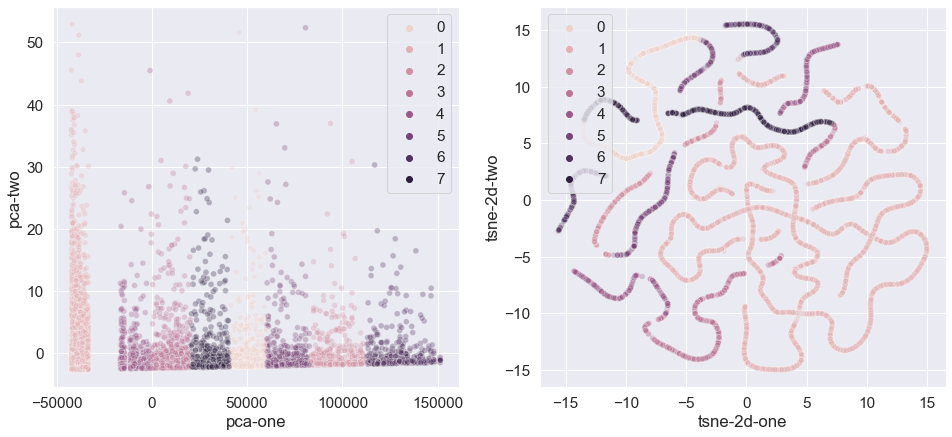

In [215]:

#plot

plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue=all_predictions,
    #palette=sns.color_palette("hls", 10),
    data=movie_df2,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x=movie_df2['tsne-2d-one'], y=movie_df2['tsne-2d-two'],
    hue=all_predictions,
    #palette=sns.color_palette("hls", 10),
    data=movie_df2,
    legend="full",
    alpha=0.3,
    ax=ax2
)

#### For all gener dataset

In [216]:
# Declaring Model
model = KMeans(n_clusters=8)

# Fitting Model
model.fit(Genre_ratingsDF2.values)

# Predicitng a single input
#predicted_label = model.predict([[7.2, 3.5, 0.8, 1.6]])

# Prediction on the entire data
all_predictions = model.predict(Genre_ratingsDF2.values)

# Printing Predictions
#print(predicted_label)
print(all_predictions)

[1 7 6 2 4 1 1 4 1 0 7 6 7 4 4 2 2 2 6 5 1 2 2 0 0 7 1 2 2 0 5 5 1 5 4 6 4
 5 1 4 1 2 4 3 5 4 5 3 0 2 2 5 7 4 6 0 2 4 2 0 7 1 2 2 7 1 4 2 7 5 3 7 4 2
 4 7 3 0 2 0 6 5 0 2 6 4 3 7 5 5 2 0 4 4 2 1 0 0 4 4 3 4 2 1 2 0 4 4 2 6 5
 4 1 3 1 4 4 7 2 3 5 2 4 0 2 4 6 7 1 4 2 2 4 4 2 4 2 0 6 2 1 4 5 5 4 0 4 0
 6 3 3 2 6 0 4 2 0 6 0 1 3 4 6 7 4 2 1 2 5 4 4 4 0 4 6 4 2 5 4 6 4 2 4 5 0
 2 2 1 0 2 2 7 0 6 1 0 7 1 2 2 4 2 4 1 5 3 6 7 0 0 1 1 0 3 2 2 6 6 2 5 2 2
 2 0 3 5 2 0 4 4 7 2 2 4 5 3 0 7 2 4 4 4 0 7 6 1 1 3 2 4 5 3 2 2 6 5 3 0 3
 2 7 3 2 0 4 2 4 6 3 3 6 4 4 2 2 0 3 4 1 5 0 5 0 4 6 1 6 2 5 2 0 5 6 6 1 5
 6 6 7 7 4 7 0 4 1 3 2 3 1 5 6 2 1 4 6 6 2 2 0 3 0 2 4 6 2 2 4 2 6 4 2 2 6
 5 7 1 4 6 2 4 4 3 2 4 6 2 4 5 4 3 1 1 5 2 4 1 2 0 4 6 0 1 3 3 6 0 1 6 5 2
 1 2 4 4 0 1 2 4 4 2 5 4 7 6 2 6 2 3 3 5 2 6 5 6 4 3 6 5 0 0 4 0 4 4 1 3 0
 5 5 2 5 2 7 2 2 6 0 2 2 2 4 1 7 1 1 0 5 2 1 0 6 1 7 5 4 4 5 2 0 1 0 6 0 4
 4 4 4 2 6 4 3 1 2 6 4 3 0 4 4 0 7 2 5 1 1 0 6 4 1 4 0 7 3 2 4 4 2 4 5 2 6
 4 2 2 4 4 0 2 2 0 0 0 7 

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 610 samples in 0.002s...
[t-SNE] Computed neighbors for 610 samples in 0.026s...
[t-SNE] Computed conditional probabilities for sample 610 / 610
[t-SNE] Mean sigma: 1.921632
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.020210
[t-SNE] KL divergence after 300 iterations: 0.704656


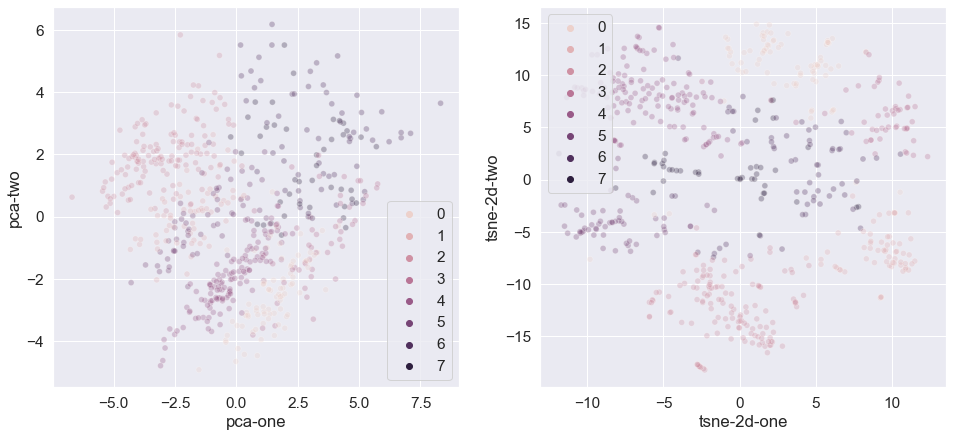

In [217]:
#pca
Genre_ratingsDF2=Genre_ratingsDF.copy()
Genre_ratingsDF2=Genre_ratingsDF2.fillna(0)
x = Genre_ratingsDF2.values
principalComponents = pca.fit_transform(x)
features = Genre_ratingsDF2.columns
#pca = PCA(n_components=2)
pca.fit(x)
pca = PCA(n_components=3)
pca_result = pca.fit_transform(Genre_ratingsDF2.values)
Genre_ratingsDF2['pca-one'] = pca_result[:,0]
Genre_ratingsDF2['pca-two'] = pca_result[:,1] 
Genre_ratingsDF2['pca-three'] = pca_result[:,2]
#print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

#t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(x)
Genre_ratingsDF2['tsne-2d-one'] = tsne_results[:,0]
Genre_ratingsDF2['tsne-2d-two'] = tsne_results[:,1]
#print('t-SNE is done!')
#plot

plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue=all_predictions,
    data=Genre_ratingsDF2,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x=Genre_ratingsDF2['tsne-2d-one'], y=Genre_ratingsDF2['tsne-2d-two'],
    
    hue=all_predictions,
    data=Genre_ratingsDF2,
    legend="full",
    alpha=0.3,
    ax=ax2
)

# 3.2 NMF cluster for data

In [218]:
from sklearn.decomposition import NMF
Genre_ratingsDF2=Genre_ratingsDF.fillna(0)
Genre_ratingsDF2[Genre_ratingsDF2<0]=0.01
nmf = NMF(n_components=10)
nmf.fit(Genre_ratingsDF2.values)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=10, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)